## Imports

In [1]:
import time
from IPython.display import clear_output
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
import sklearn  as skl

from sklearn import pipeline      # Pipeline
from sklearn import preprocessing # OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config

set_config(display='diagram') # Useful for display the pipeline
sb.set_style("whitegrid")
skl.set_config(display='diagram')

print("Pandas  ", pd.__version__)
print("Sklearn ", skl.__version__) # Try to use 0.24

Pandas   1.1.3
Sklearn  0.23.2


In [10]:
# CLASSIFIERS

# MULT
from sklearn.linear_model   import LogisticRegression
from sklearn.linear_model   import RidgeClassifier
from sklearn.svm            import SVC
from sklearn.svm            import NuSVC
from sklearn.svm            import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes    import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble       import StackingClassifier

#TREE
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.experimental  import enable_hist_gradient_boosting
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier, plot_tree
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier
r

#REGRESSORS
from sklearn.linear_model  import ElasticNet, Ridge, Lasso, BayesianRidge, ARDRegression, TweedieRegressor
from sklearn.svm           import LinearSVR, NuSVR, SVR
from sklearn.ensemble      import BaggingRegressor
from sklearn.kernel_ridge  import KernelRidge

## Get the dataset
- **CLOUD = True**: Download dataset from Kaggle. Necesary for cloud enviroments like COLAB. **Specify your [kaggle credentials](https://www.kaggle.com/docs/api)**.
- **CLOUD = False**: Get the dataset from your local machine. **Specify the data path**.

In [2]:
CLOUD = False

if CLOUD:
    import os
    os.environ['KAGGLE_USERNAME'] = "your_kaggle_username"
    os.environ['KAGGLE_KEY']      = "your_kaggle_api_key"  # See https://www.kaggle.com/docs/api
    !pip install --upgrade kaggle
    !kaggle competitions download -c titanic
    DATA_PATH = "./"

else:
    DATA_PATH = "../../Datasets/Tabular/titanic/"

## Load data

In [3]:
df      = pd.read_csv(DATA_PATH + "train.csv", index_col='PassengerId')
df_test = pd.read_csv(DATA_PATH + "test.csv",  index_col='PassengerId')

print("Train DataFrame:", df.shape)
print("Test DataFrame: ", df_test.shape)

Train DataFrame: (891, 11)
Test DataFrame:  (418, 10)


## Check missings

In [4]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [5]:
df_test.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

# Exercise 1 (2pts):
Extract the title (Mr, Mrs, ... ) from the "Name" column.

Tips:
- split(',')[1] to get the 2nd part, and remove the surnamename
- split('.')[0] to get the 1str part, and remove the name

In [6]:
# CODE HERE get_Title_from_Name funtion
# Create this function using lambda (not def)

get_Title_from_Name = lambda name: name.split(',')[1].split('.')[0].strip()


df['Title']      = df['Name'].map(get_Title_from_Name)
df_test['Title'] = df_test['Name'].map(get_Title_from_Name)

# Exercise 2 (1pts):
Apply the title_dictionary to get a better information about the title. You have to overwrite the Title variable.

In [7]:
title_dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty",
    "Dona" : "Royalty"
}

In [8]:
# Use map to apply the prevous dict

df["Title"] = df.Title.map(title_dictionary)
df_test["Title"] = df_test.Title.map(title_dictionary)



In [9]:
assert df['Title'].values[886] == "Officer"
assert df_test['Title'].values[417] == "Master"

# Exercise OPTINAL (0pts):
Try to extract some information from the feature **Ticket**. Search on Internet if that colum has some kind of information.

In [23]:
df_test['Ticket']

PassengerId
892                 330911
893                 363272
894                 240276
895                 315154
896                3101298
               ...        
1305             A.5. 3236
1306              PC 17758
1307    SOTON/O.Q. 3101262
1308                359309
1309                  2668
Name: Ticket, Length: 418, dtype: object

# Exercise OPTIONAL (0pts):
Try to extract some information from the feature **Cabin**. Search on Internet if that colum has some kind of information.

In [24]:
df_test['Cabin']

PassengerId
892      NaN
893      NaN
894      NaN
895      NaN
896      NaN
        ... 
1305     NaN
1306    C105
1307     NaN
1308     NaN
1309     NaN
Name: Cabin, Length: 418, dtype: object

# Preprocessing
For X data, notice that...
- We drop Survived because is the target variable
- We drop Name because we have extracted the Title: Mr, Mrs, ...
- We drop Ticket because it has no information -> see df.Ticket.nunique()
- We drop Cabin because it has a lot of missings (77% are missings)

Then, we identify **numerical** variables and **categorical** variables,

In [11]:
x = df.drop(columns=["Survived", 'Name', 'Ticket', 'Cabin']) # X DATA (WILL BE TRAIN+VALID DATA)
y = df["Survived"] # 0 = No, 1 = Yes

x_test = df_test.drop(columns=['Name', 'Ticket', 'Cabin']) # # X_TEST DATA (NEW DATA)

In [12]:
age_var   = ['Age', 'Sex', 'Pclass', 'Title']
cat_vars  = ['Sex', 'Embarked', 'Title']         # x.select_dtypes(include=[object]).columns.values.tolist()
num_vars  = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age'] # x.select_dtypes(exclude=[object]).columns.values.tolist()

print("\nNumerical features:\n", num_vars)
print("\nCategorical features:\n", cat_vars)


Numerical features:
 ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age']

Categorical features:
 ['Sex', 'Embarked', 'Title']


In [13]:
df.groupby(['Sex','Pclass','Title']).Age.agg(["mean","median","count"]).reset_index(drop=False)

,Sex,Pclass,Title,mean,median,count
0,female,1,Miss,29.744681,30.0,47
1,female,1,Mrs,40.400000,40.0,35
2,female,1,Officer,49.000000,49.0,1
3,female,1,Royalty,40.500000,40.5,2
4,female,2,Miss,22.390625,24.0,32
5,female,2,Mrs,33.547619,31.5,42
6,female,3,Miss,16.123188,18.0,69
7,female,3,Mrs,33.515152,31.0,33
8,male,1,Master,5.306667,4.0,3
9,male,1,Mr,41.580460,40.0,87


# Exercise 3 (2pts):
Create a **ColumnTransformer for Tree Models**. You need to create 2 pipelines (one for numerical and other for categories). Remember:
- Categorical pipeline: Some SimpleImputer -> Some Encoder
- Numerical pipeline: Some SimpleImputer -> NO Encoder

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class GroupImputer(BaseEstimator, TransformerMixin):

    def __init__(self, group_cols, target, metric='mean'):
        
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(target) == str, 'target should be a string'
        
        self.group_cols = group_cols
        self.target = target
        self.metric = metric
    
    def fit(self, X, y=None):
        
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'
        
        impute_map = X.groupby(self.group_cols)[self.target].agg(self.metric).reset_index(drop=False)
        
        self.impute_map_ = impute_map
        
        return self 
    
    def transform(self, X, y=None):
        
        check_is_fitted(self, 'impute_map_') # make sure that the imputer was fitted
        
        X = X.copy()
        
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind] = X.loc[ind].fillna(row[self.target])
        
        return X[[self.target]].values

In [15]:
num_4_multModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean', add_indicator=True)), # mean, median
    ('scaler', preprocessing.StandardScaler())
])

cat_4_multModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore'))
])

age_4_multModels = pipeline.Pipeline(steps=[
    ('imputer', GroupImputer(group_cols=['Sex','Pclass','Title'], target='Age', metric='mean')),
    ('scaler', preprocessing.StandardScaler())
])

mult_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_4_multModels, num_vars),
    ('cat', cat_4_multModels, cat_vars),
    ('age', age_4_multModels, age_var),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

mult_prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True)),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked', 'Title']),
                                ('age',
                                 Pipeline(steps=[('imputer',
                                                  GroupImputer(group_cols=['Sex',
                                                                           'Pclass',
                                                                           'Title'],
                                                               target='Age')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Sex', 'Pclass', 'Title'])])

In [16]:

num_4_treeModels = pipeline.Pipeline(steps=[
  ('imputer', impute.SimpleImputer(strategy='constant', fill_value=-9999))
])

cat_4_treeModels = pipeline.Pipeline(steps=[
   ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore')) # specify unknowns 
])

tree_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_4_treeModels, num_vars),
    ('cat', cat_4_treeModels, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

tree_prepro


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=-9999,
                                                                strategy='constant'))]),
                                 ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked', 'Title'])])

In [29]:
assert type(tree_prepro)      is compose._column_transformer.ColumnTransformer
assert type(num_4_treeModels) is pipeline.Pipeline
assert type(cat_4_treeModels) is pipeline.Pipeline
assert len(num_4_treeModels) == 1
assert len(cat_4_treeModels) == 2

# Exercise 4 (1pts):
1. Complete the diccionary with some Tree Models.
2. Then we put each model in a Pipeline where:
   - first is the prepocessing with the column Transformer
   - Then is the Tree model
3. Display the fullpipeline of the LGBMClassifier

In [30]:
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.experimental  import enable_hist_gradient_boosting # Necesary for HistGradientBoostingClassifier
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier

In [17]:
mult_classifiers = {
  "LogRegr":        LogisticRegression(),
  #"Ridge":          RidgeClassifier(),
  "SVM_lin":         SVC(kernel="linear", probability=True), # C=0.025
  "SVM_rbf":         SVC(kernel='rbf', probability=True),
  "NuSVC":           NuSVC(probability=True),
  #"LinearSVC":       LinearSVC(),
  "KNN3":            KNeighborsClassifier(3),
  "KNN5":            KNeighborsClassifier(5),
# "GP":              GaussianProcessClassifier(1.0 * RBF(1.0)),
# "GaussianNB":      GaussianNB()
}

tree_classifiers = {
  "Decision Tree": DecisionTreeClassifier(),
  "Extra Trees":   ExtraTreesClassifier(n_estimators=100),
  "Random Forest": RandomForestClassifier(n_estimators=100),
  "AdaBoost":      AdaBoostClassifier(n_estimators=100),
  "Skl GBM":       GradientBoostingClassifier(n_estimators=100),
  "Skl HistGBM":   HistGradientBoostingClassifier(),
  "XGBoost":       XGBClassifier(n_estimators=100),
  "LightGBM":      LGBMClassifier(n_estimators=100),
  "CatBoost":      CatBoostClassifier(n_estimators=100),
# "NGBoost":       NGBClassifier(n_estimators=100),
# "RGF":           RGFClassifier(n_jobs=-1),
# "FastRGF":       FastRGFClassifier())
}


mult_classifiers = {name: pipeline.make_pipeline(mult_prepro, model) for name, model in mult_classifiers.items()}
tree_classifiers = {name: pipeline.make_pipeline(tree_prepro, model) for name, model in tree_classifiers.items()}

models = {**mult_classifiers, **tree_classifiers}

In [31]:

tree_classifiers = {
  "Decision Tree": DecisionTreeClassifier(),
  "Extra Trees":   ExtraTreesClassifier(n_estimators=100),
  "Random Forest": RandomForestClassifier(n_estimators=100),
  "AdaBoost":      AdaBoostClassifier(n_estimators=100),
  "Skl GBM":       GradientBoostingClassifier(n_estimators=100),
  "Skl HistGBM":   HistGradientBoostingClassifier(max_iter=100),
  "XGBoost":       XGBClassifier(n_estimators=100),
  "LightGBM":      LGBMClassifier(n_estimators=100),
  "CatBoost":      CatBoostClassifier(n_estimators=100),
} 



   
tree_classifiers = {name: pipeline.make_pipeline(tree_prepro, model) for name, model in tree_classifiers.items()}
tree_classifiers["LightGBM"]





Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-9999,
                                                                                 strategy='constant'))]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked',
                                                   'Title'])])),
                ('lgbmclassifier', LGBMClassifier())])

In [32]:
for pipe in tree_classifiers.values():
    assert type(pipe) is pipeline.Pipeline

# Exercise 5 (3pts):
Define a simple split validation strategy with:
- 80% for train
- 20% for validation
- With stratification
- random_state=0

And train all the models in a for loop

In [34]:

x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x, y,
    test_size=0.2,
    stratify = y,   
    random_state=4  
)

results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})

for model_name, model in tree_classifiers.items():

    start_time = time.time()
    model.fit(x_train, y_train)
    total_time = time.time() - start_time
    
    pred = model.predict(x_val)
    
    results = results.append({"Model":    model_name,
                              "Accuracy": metrics.accuracy_score(y_val, pred)*100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y_val, pred)*100,
                              "Time":     total_time},
                              ignore_index=True)
    
    results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
    results_ord.index += 1 
    
    clear_output(wait=True)
    display(results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d'))

,Model,Accuracy,Bal Acc.,Time
1,XGBoost,88.268156,86.943347,0.162074
2,LightGBM,85.474860,84.400527,0.119681
3,AdaBoost,84.916201,84.216074,0.153584
4,Skl HistGBM,84.916201,83.675889,1.076207
5,Skl GBM,84.357542,83.221344,0.092719
6,CatBoost,84.357542,82.681159,0.215438
7,Random Forest,83.240223,81.772069,0.158606
8,Decision Tree,81.564246,81.218709,0.009974
9,Extra Trees,80.446927,79.229249,0.133230


In [35]:
assert results_ord["Accuracy"].min() > 75
assert results_ord["Bal Acc."].min() > 75
assert len(results_ord) == 9

# Exercise 6 (3pts):
Define a 10 Fold cross validation strategy with:
- With stratification
- shuffle=True
- random_state=0

And train all the models in a for loop.

Tip you can use **[cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)** for both training and predict with 

In [18]:
preds = {}
skf = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'AUC': [], 'Time': []})


preds_abs = {}
preds_pro = {}

for model_name, model in models.items(): 
            
    start_time = time.time()
    pred_abs = model_selection.cross_val_predict(model, x, y, cv=skf)
    total_time = time.time() - start_time
    preds_abs[model_name] = pred_abs
    
    start_time = time.time()
    pred_pro = model_selection.cross_val_predict(model, x, y, cv=skf, method="predict_proba")[:,1]
    total_time = time.time() - start_time
    preds_pro[model_name] = pred_pro
    
    results = results.append({"Model":    model_name,
                              "Accuracy": metrics.accuracy_score(y, pred_abs)*100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y, pred_abs)*100,
                              "AUC":      metrics.roc_auc_score(y, pred_pro)*100,
                              "Time":     total_time},
                              ignore_index=True)
    
    results_ord = results.sort_values(by=["Accuracy"], ascending=False, ignore_index=True)
    results_ord.index += 1 

    clear_output(wait=True)
    display(results_ord.style.bar(subset=["Accuracy", "Bal Acc.", "AUC"], vmin=0, vmax=100, color='#5fba7d'))

,Model,Accuracy,Bal Acc.,AUC,Time
1,Skl GBM,83.726150,81.998370,86.751829,0.975724
2,LogRegr,83.164983,81.653245,86.728129,2.015180
3,SVM_rbf,83.164983,81.102004,84.154603,1.897043
4,NuSVC,82.940516,81.030103,84.273906,2.071154
5,Skl HistGBM,82.828283,81.324897,86.538257,12.954127
6,SVM_lin,82.716049,81.068450,85.230989,1.946044
7,LightGBM,82.603816,81.142748,86.748900,1.472984
8,CatBoost,82.379349,79.968364,86.068503,2.468025
9,XGBoost,81.818182,80.394977,86.513224,2.056112
10,AdaBoost,81.369248,80.361423,86.263701,1.457101


In [19]:
preds_df = pd.DataFrame(preds_pro, index=df.index)
preds_df["Target"] = y
preds_df.head()

,LogRegr,SVM_lin,SVM_rbf,NuSVC,KNN3,KNN5,Decision Tree,Extra Trees,Random Forest,AdaBoost,Skl GBM,Skl HistGBM,XGBoost,LightGBM,CatBoost,Target
PassengerId,,,,,,,,,,,,,,,,
1,0.065198,0.093693,0.122983,0.119981,0.333333,0.4,0.0,0.34,0.210833,0.492203,0.068443,0.084038,0.069616,0.110899,0.097879,0
2,0.971094,0.892014,0.928656,0.907452,1.000000,1.0,1.0,1.00,0.980000,0.509756,0.979090,0.999658,0.999718,0.999122,0.966704,1
3,0.570936,0.768633,0.584717,0.747309,0.666667,0.4,0.0,0.93,0.610000,0.504316,0.430701,0.248803,0.295884,0.411939,0.439836,1
4,0.942049,0.837219,0.899039,0.903158,1.000000,1.0,1.0,1.00,1.000000,0.512850,0.979470,0.998938,0.999657,0.998351,0.958758,1
5,0.076882,0.140765,0.158044,0.145991,0.000000,0.0,0.0,0.00,0.025000,0.496094,0.157703,0.033426,0.021806,0.020971,0.115351,0


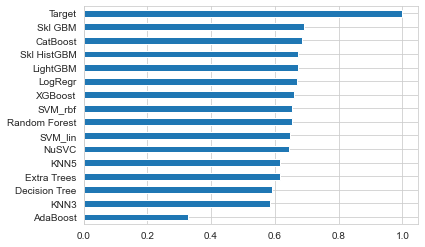

In [20]:
preds_df.corr().Target.sort_values().plot.barh();

In [21]:
models["LogRegr"]

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked', 'Title']),
                                                 ('age',
                                                  Pipeline(steps=[('imputer',
                                                                   GroupImputer(group_cols=['Sex',
                                                                                            'Pclass',
                                                                                            'Title'],
                                                                                target='Age')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Sex', 'Pclass',
                                                   'Title'])])),
                ('logisticregression', LogisticRegression())])

In [22]:
models_ensemble = [
    ('LightGBM', models["LightGBM"]),
    #('CatBoost', models["CatBoost"]),
    ("LogRegr",  models["LogRegr"]),
    #("KNN5",     models["KNN5"]),
]

ensamble = StackingClassifier(estimators=models_ensemble, cv=20, final_estimator=LogisticRegression())
ensamble

StackingClassifier(cv=20,
                   estimators=[('LightGBM',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value=-9999,
                                                                                                                 strategy='constant'))]),
                                                                                  ['Pclass',
                                                                                   'SibSp',
                                                                                   'Parch',
                                                                                   'Fare',
                                                                                   'Age']),
                                                                                 ('cat',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value='missing',
                                                                                                                 strategy='constant')),
                                                                                                  ('onehot',
                                                                                                   O...
                                                                                                                 strategy='constant')),
                                                                                                  ('onehot',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  ['Sex',
                                                                                   'Embarked',
                                                                                   'Title']),
                                                                                 ('age',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   GroupImputer(group_cols=['Sex',
                                                                                                                            'Pclass',
                                                                                                                            'Title'],
                                                                                                                target='Age')),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Age',
                                                                                   'Sex',
                                                                                   'Pclass',
                                                                                   'Title'])])),
                                                ('logisticregression',
                                                 LogisticRegression())]))],
                   final_estimator=LogisticRegression())

In [23]:
ensamble.fit(x,y)

StackingClassifier(cv=20,
                   estimators=[('LightGBM',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value=-9999,
                                                                                                                 strategy='constant'))]),
                                                                                  ['Pclass',
                                                                                   'SibSp',
                                                                                   'Parch',
                                                                                   'Fare',
                                                                                   'Age']),
                                                                                 ('cat',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value='missing',
                                                                                                                 strategy='constant')),
                                                                                                  ('onehot',
                                                                                                   O...
                                                                                                                 strategy='constant')),
                                                                                                  ('onehot',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  ['Sex',
                                                                                   'Embarked',
                                                                                   'Title']),
                                                                                 ('age',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   GroupImputer(group_cols=['Sex',
                                                                                                                            'Pclass',
                                                                                                                            'Title'],
                                                                                                                target='Age')),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Age',
                                                                                   'Sex',
                                                                                   'Pclass',
                                                                                   'Title'])])),
                                                ('logisticregression',
                                                 LogisticRegression())]))],
                   final_estimator=LogisticRegression())

In [24]:
test_pred = ensamble.predict(x_test)
test_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [25]:
sub = pd.DataFrame(test_pred, index=x_test.index, columns=["Survived"])
sub.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [26]:
sub.to_csv("sub.csv")

# Exercise 7.1
Train with all data the best model

In [38]:

best_model =   tree_classifiers["Skl GBM"] 
best_model.fit(x,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-9999,
                                                                                 strategy='constant'))]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked',
                                                   'Title'])])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

# Exercise 7.2 (2pts)
With your best model, generate the predicitions for test data (x_test)

In [39]:
test_pred = best_model.predict(x_test)

In [40]:
assert len(test_pred) == 418
assert np.unique(test_pred).tolist() == [0,1]

# Exercise 7.3

Submit to kaggle.

- You can use the kaggle command line app. Check https://github.com/Kaggle/kaggle-api

In [79]:
sub = pd.DataFrame(test_pred, index=x_test.index, columns=["Survived"])
sub.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0


In [80]:
sub.to_csv("sub.csv")

In [ ]:
!kaggle competitions submit -c titanic -f sub.csv -m "My submission message"